In [1]:
import pandas as pd
import numpy as np
from scipy import stats, special
from scipy.optimize import minimize 

import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load Data
db = pd.read_csv('data/mon.csv')

# add serial number for participants
db['subn'] = db['sub'].rank(method='dense').astype(int)-1
db['subject'] = db['subn'].astype('category')

# remove missing trials
db = db.dropna()
db['choice'] = db['choice'].astype('int')

# sort dataframe based on subject, makes it easier to compare the output of the models.
db = db.sort_values('subn').reset_index(drop=True)
db.head()

,Unnamed: 0,choice,value,risk,ambiguity,sub,catch,subn,subject
0,40,0,8,0.5,0.00,10,0.0,0,0
1,23,0,8,0.5,0.50,10,0.0,0,0
2,24,0,5,0.5,0.50,10,0.0,0,0
3,25,0,8,0.5,0.00,10,0.0,0,0
4,26,1,25,0.5,0.24,10,0.0,0,0


In [9]:
def MLE_riskamb(parameters):
    # extract parameters
    α, β, γ = parameters
    
    # caclulate proportion between SVs
    svLotto = (db_sub['value'].values ** α) * (1-(db_sub['risk'].values+(β * (db_sub['ambiguity'].values/2))))
    svRef = 5 ** α
    #p = 1/(1+np.exp((svRef - svLotto) * γ))
    p = special.expit((svRef - svLotto) * γ) 
    #size = len(p)
    #mu = np.random.binomial(1,p,size)
    
    # Calculate the log-likelihood for normal distribution
    LL = np.sum(stats.norm.logpdf(db_sub.choice, p))
    # Calculate the negative log-likelihood
    neg_LL = -1*LL
    return neg_LL 

In [13]:
subs = db['sub'].unique()
mLL = pd.DataFrame()

for sub in subs:
    db_sub = db[db['sub']==sub]
    mle_model = minimize(MLE_riskamb, np.array([1,1,1]), method='L-BFGS-B', 
                         bounds=[(0,2),(-2,2),(-np.inf,np.inf)])
    x = mle_model.x
    temp = {'sub': sub, 'alpha' : x[0], 'beta': x[1], 'gamma': x[2]}
    mLL = mLL.append(temp,ignore_index=True)
mLL.head()

,alpha,beta,gamma,sub
0,1.045656,0.702963,-0.913220,10.0
1,2.000000,-2.000000,0.049826,11.0
2,0.000000,-1.645432,1.652540,13.0
3,0.000000,2.000000,-25.894275,14.0
4,0.415824,-2.000000,0.680582,15.0


In [15]:
n_subs = max(db.subn)+1
total_trials = db.shape[0]

# constant in this experiment
refValue       = 5
refProbability = 1
refAmbiguity   = 0

# create long lists for the stan model
refProbabilities = np.tile(refProbability, total_trials)
refValues        = np.tile(refValue,       total_trials)
refAmbiguities   = np.tile(refAmbiguity,   total_trials)

In [16]:
values    = np.array(db.value)
risk      = np.array(db.risk)
ambiguity = np.array(db.ambiguity)
choices   = np.array(db.choice)

n_trials = np.arange(len(choices))

#sub_idx = np.arange(n_subs)
#sub_idx = np.repeat(sub_idx, 84)
sub_idx = db.subn.tolist()


In [19]:
with pm.Model() as RiskAmb:
    # hyper
    aMu = pm.Normal('rMu', 0.7 ,1)
    aSig = pm.Exponential('rSig', 1)
    bMu = pm.Normal('aMu', 0,1)
    bSig = pm.Exponential('aSig', 1)
    
    gMu = pm.Normal('nMu', 0,1)
    gSig = pm.Exponential('nSig', 1)
    
    
    α = pm.TruncatedNormal('α', aMu, aSig, lower = 0, upper = 2, shape = n_subs)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
    # Priors for unknown model parameters
    
      
    # Expected value of outcome
    svLotto = (db['value'].values ** α[sub_idx]) * (1-(db['risk'].values + (β[sub_idx] * (db['ambiguity'].values/2))))
    svRef = 5 ** α[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db['choice'])
    trace = pm.sample(4000, return_inferencedata=True, target_accept=0.95)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, β, α, nSig, nMu, aSig, aMu, rSig, rMu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 810 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'γ'}>,
        <AxesSubplot:title={'center':'γ'}>]], dtype=object)

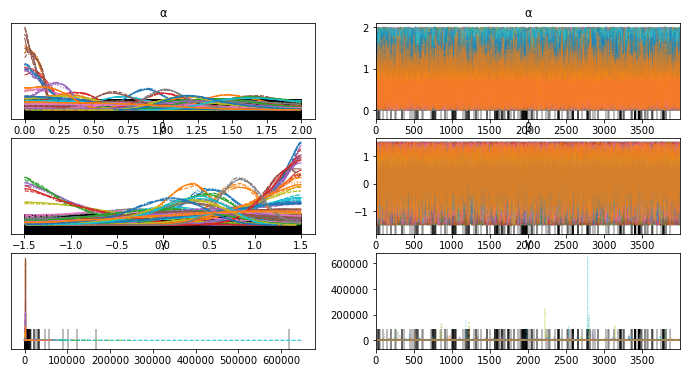

In [20]:
az.plot_trace(trace, var_names=['α','β','γ'])

In [ ]:
model_compare = az.compare(
    {
        "old": trace2,
        "new": trace3,
    }
)
az.plot_compare(model_compare, figsize=(12, 4))

plt.show()


In [ ]:
with RiskAmb:
    ppc = pm.sample_posterior_predictive(
        trace3
    )

In [ ]:
ppc['choice'].shape

In [ ]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=RiskAmb))

In [ ]:
pc = az.from_pymc3(posterior_predictive=ppc, model=RiskAmb)
pp = np.mean(pc.posterior_predictive.choice.values, axis=1)

In [ ]:
np.sum((choices-pp)**2)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
pp

In [ ]:
x = pp[0].T.shape

In [ ]:
len(choices)

In [ ]:
cf_matrix = confusion_matrix(choices, pp[0].T)
print(cf_matrix)

In [ ]:
az.summary(trace2, var_names=['α'])[:5]

In [ ]:
az.summary(trace2, var_names=['β'])[:5]

In [ ]:
df = db[['sub','subn']].sort_values('subn').drop_duplicates().reset_index(drop=True)

age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='scans').iloc[:, [1,7,8]]
age.columns.values[0] = "sub"
age['sub'] = age['sub'].map(lambda x: int(x.lstrip('AG_')))

df = df.merge(age, left_on='sub', right_on='sub')
df.head()

In [ ]:
alpha = az.summary(trace3, var_names=['α'])[['mean','sd']]
beta = az.summary(trace3, var_names=['β'])[['mean','sd']]

alpha = alpha.rename(columns={'mean': "alpha", 'sd': 'alpha_sd'}).reset_index(drop=True)
beta = beta.rename(columns={'mean': "beta", 'sd': 'beta_sd'}).reset_index(drop=True)

df = df.merge(alpha, left_index=True, right_index=True)
df = df.merge(beta, left_index=True, right_index=True)

df.head()

In [ ]:
sns.regplot(x='Age', y='alpha', data=df)

In [ ]:
sns.regplot(x='Age', y='beta', data=df)

In [ ]:
d10 = db[db['sub']==10]
d10.head()

In [ ]:
sns.regplot(x='value',y='choice', data=d10, logistic=True)

In [ ]:
svRef = 5 ** df.alpha[0]
svLotto = d10.value ** df.alpha[0] * (d10.risk - df.beta[0] * (d10.ambiguity/2))
p = sp.special.expit(svLotto - svRef)

d10['sim'] = np.random.binomial(1, p, len(p))
d10.head()

In [ ]:
sns.scatterplot(x='value', y='choice', data = d10, alpha=0.3)
sns.regplot(x='value',y='sim', data=d10, logistic=True, scatter=False , color='red')
sns.regplot(x='value',y='choice', data=d10, logistic=True, scatter=False , color='green')

In [ ]:
db.groupby('choice').count()